**Class III Sugarcane Mill Predictive Maintenance**

| Library                                                                | Purpose                          |
| ---------------------------------------------------------------------- | -------------------------------- |
| `pandas, numpy`                                                        | Data handling                    |
| `matplotlib, seaborn`                                                  | 2D plots                         |
| `scikit-learn`                                                         | ML models, preprocessing         |
| `imbalanced-learn`                                                     | SMOTE                            |
| `scipy`                                                                | FFT, Welch spectral analysis     |
| `shap`                                                                 | Explainable AI                   |
| `tensorflow`                                                           | LSTM for RUL                     |
| `streamlit`                                                            | Dashboard                        |
| `openpyxl`                                                             | Excel export                     |
| `plotly`                                                               | 3D interactive plots             |
| `line_notify`                                                          | LINE notifications               |
| `google-api-python-client, google-auth-httplib2, google-auth-oauthlib` | Google Calendar/CMMS integration |


In [ ]:
# ==========================
# 4️) Feature Engineering
# ==========================
def engineer_features(df):
    rolling_windows = [3,5,10]
    for w in rolling_windows:
        for col in ['Speed_Motor_rpm','Vrms_Est_mm_s','Torque_Nm','Current_A']:
            df[f'{col}_mean_{w}'] = df[col].rolling(w).mean()
            df[f'{col}_std_{w}'] = df[col].rolling(w).std()
            df[f'{col}_min_{w}'] = df[col].rolling(w).min()
            df[f'{col}_max_{w}'] = df[col].rolling(w).max()

    # Spectral RMS (Welch)
    fs = 1
    f, Pxx = welch(df['Vrms_Est_mm_s'].values, fs=fs)
    df['Vrms_Spectral_RMS'] = np.sqrt(np.mean(Pxx))

    # FFT peaks
    fft_vals = fft(df['Vrms_Est_mm_s'].values)
    df['FFT_peak'] = np.abs(fft_vals).max()

    # Risk labeling (ISO 10816 Class III)
    def classify_risk(rms):
        if rms <= 0.71:
            return 'Good'
        elif rms <= 1.8:
            return 'Satisfactory'
        elif rms <= 4.5:
            return 'Unsatisfactory'
        else:
            return 'Unacceptable'
    df['Risk_Level_ISO10816'] = df['Vrms_Est_mm_s'].apply(classify_risk)

    # Encode categorical
    le_section = LabelEncoder()
    df['Section_enc'] = le_section.fit_transform(df['Section'])
    le_risk = LabelEncoder()
    df['Risk_enc'] = le_risk.fit_transform(df['Risk_Level_ISO10816'])

    return df, le_risk

#POC System Y058



---


**Dataset** ` feedmill_clean_long.csv`



---



In [1]:
# Core Data & ML
%pip install pandas numpy scikit-learn imbalanced-learn xgboost lightgbm scipy shap tensorflow keras

# Dashboard & Visualization
%pip install streamlit matplotlib seaborn plotly

# Excel / PDF
%pip install openpyxl xlsxwriter reportlab PyPDF2 pdfkit fpdf

# Notifications & API
%pip install requests smtplib

# Google API for Calendar integration
%pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib

# Optional: scheduling tasks
%pip install schedule APScheduler

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'fpdf' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'fpdf'. Discussion can be found at https://github.com/pypa/pip/issues/6334



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--


ERROR: Could not find a version that satisfies the requirement smtplib (from versions: none)
ERROR: No matching distribution found for smtplib


   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
    ----------------

# Exploratory Data Analysis for predictive maintenance insights

In [2]:
# Purpose: Full Exploratory Data Analysis for predictive maintenance insights
# -----------------------------
# 1. Imports & Settings
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
import streamlit as st
from fpdf import FPDF

In [3]:
# Settings for plots
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [4]:
# -----------------------------
# 2. Load Data
# -----------------------------
df = pd.read_csv("feedmill_clean_long.csv", parse_dates=["DateTime"])
breakdown_df = pd.read_csv("breakdown_log_detailed.csv", parse_dates=["Date"])

In [5]:
# Quick overview
print("Data Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())
print("Missing values per column:\n", df.isna().sum())

Data Shape: (647249, 6)
             DateTime Machine                        SensorName  \
0 2024-12-10 08:00:00  Mill 1                       Speed Motor   
1 2024-12-10 08:00:00  Mill 1      Temperator Brass bearing NDE   
2 2024-12-10 08:00:00  Mill 1       Temperator Bearing Motor DE   
3 2024-12-10 08:00:00  Mill 1               Temperator Oil Gear   
4 2024-12-10 08:00:00  Mill 1  Temperator Winding Motor Phase U   

                                    Tag        Value Unit  
0  110_MM_106/SpdIn.Value,800xA History  1413.601685  rpm  
1     110_TT_115AIn.Value,800xA History    23.791868    C  
2     110_TT_114BIn.Value,800xA History    38.393330    C  
3      110_TT_123In.Value,800xA History    61.132439    C  
4     110_TT_113UIn.Value,800xA History    81.670967    C  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647249 entries, 0 to 647248
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   

Insight:

เราจะเห็น sensor ไหนมี missing values เยอะ → อาจต้อง interpolate / impute

ช่วงเวลาใด sensor ทำงานไม่ครบ → เป็น indicator ของปัญหาเครื่องจักร

In [6]:
# -----------------------------
# 3. Sensor Overview
# -----------------------------
sensor_stats = df.groupby("SensorName")["Value"].describe().T
display(sensor_stats)

SensorName,Current Motor,Power Motor,Speed Motor,Speed Roller,Temperator Bearing Motor DE,Temperator Bearing Motor NDE,Temperator Brass bearing DE,Temperator Brass bearing NDE,Temperator Oil Gear,Temperator Winding Motor Phase U,Temperator Winding Motor Phase V,Temperator Winding Motor Phase W
count,53948.000000,53948.000000,53952.000000,53949.000000,53948.000000,53948.000000,53924.000000,53924.000000,53898.000000,53949.000000,53937.000000,53924.000000
mean,221.680958,173.056283,1066.785575,3.982358,40.886519,60.398360,26.754161,26.740784,43.576035,81.292204,80.007155,77.883396
std,77.008776,65.687029,392.025508,2.560294,7.175623,12.258117,3.479791,3.288605,10.165242,17.627128,17.080389,16.077986
min,0.000000,-0.218031,0.000000,0.000000,0.000000,19.702869,19.528496,19.528496,19.538683,19.776455,21.618595,21.349735
25%,236.497497,163.282451,966.651306,3.592224,36.412783,56.481390,24.373938,24.373297,39.316205,80.215439,78.805145,76.541174
50%,247.390061,200.495590,1234.746826,4.597849,40.845361,63.540476,26.338265,26.340124,41.954521,85.603889,84.144341,81.734974
75%,255.597839,210.268803,1291.456025,4.798432,45.381844,68.573484,29.050396,29.051651,45.091733,90.621544,89.135841,86.586310
max,449.547943,361.446655,1417.910645,270.201111,141.525085,93.518150,90.555176,50.001278,69.175331,104.179794,102.472801,99.229790


Insight:

Sensor ที่มี variance สูง → แสดงความเสี่ยงสูง

Mean / max / min → ดูช่วงค่าที่ปกติ vs anomaly

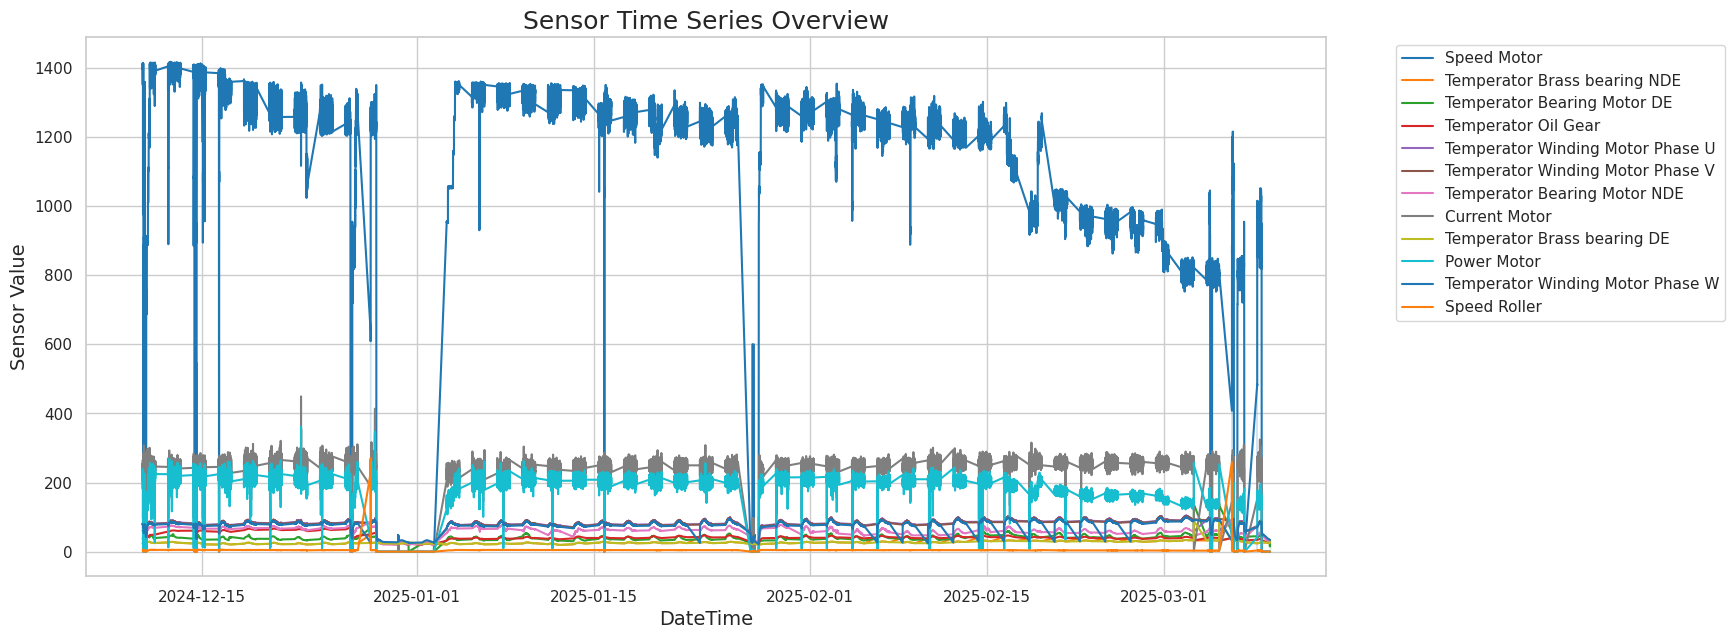

In [ ]:
# -----------------------------
# 4. Time Series Overview per Sensor
# -----------------------------
# ขอเป็นกราฟที่ละเอียดสวยดูง่าย

plt.figure(figsize=(16,7))
sns.lineplot(data=df, x="DateTime", y="Value", hue="SensorName", palette="tab10")
plt.title("Sensor Time Series Overview", fontsize=18)
plt.xlabel("DateTime")
plt.ylabel("Sensor Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

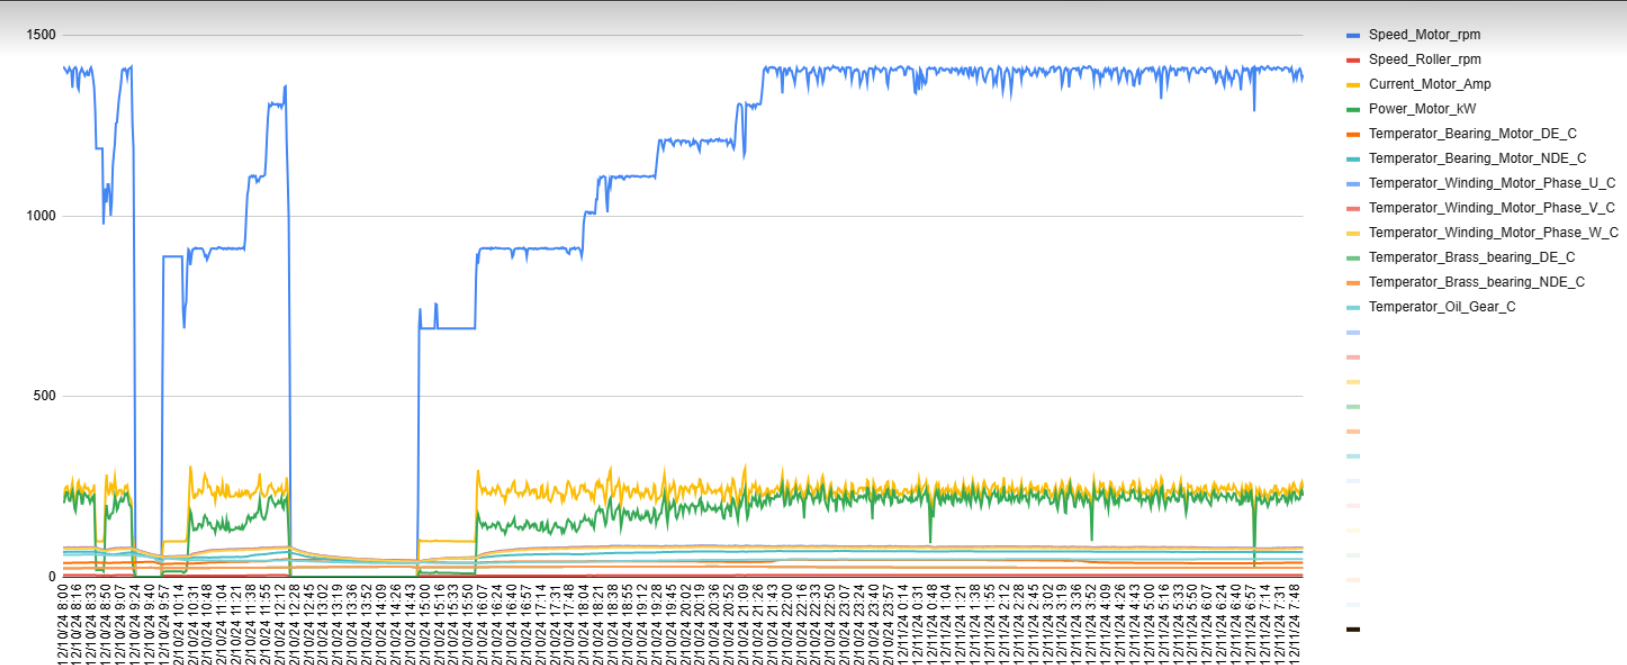

Insight:

สังเกต pattern, spike, หรือ downtime

เข้าใจว่า sensor ไหน response ช้า / ค่าผันผวนมาก

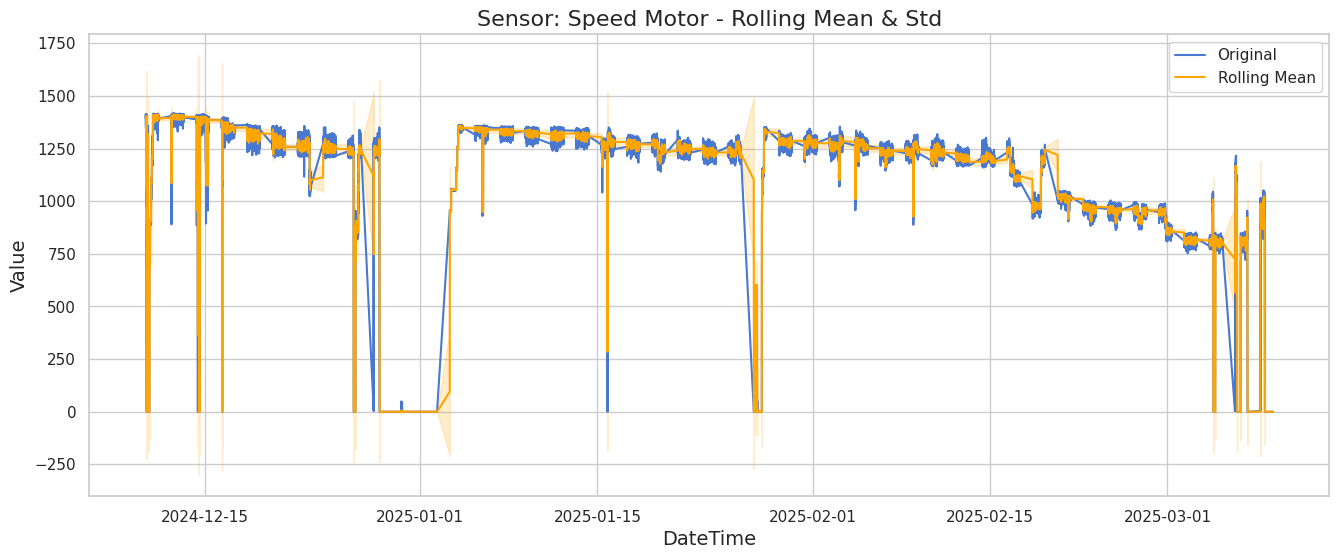

In [ ]:
# -----------------------------
# 5. Rolling Stats
# -----------------------------
df['RollingMean'] = df.groupby("SensorName")["Value"].transform(lambda x: x.rolling(10).mean())
df['RollingStd'] = df.groupby("SensorName")["Value"].transform(lambda x: x.rolling(10).std())

example_sensor = "Speed Motor"
sensor_data = df[df["SensorName"]==example_sensor]

plt.figure(figsize=(16,6))
plt.plot(sensor_data["DateTime"], sensor_data["Value"], label="Original")
plt.plot(sensor_data["DateTime"], sensor_data["RollingMean"], color='orange', label="Rolling Mean")
plt.fill_between(sensor_data["DateTime"],
                 sensor_data["RollingMean"] - sensor_data["RollingStd"],
                 sensor_data["RollingMean"] + sensor_data["RollingStd"],
                 color='orange', alpha=0.2)
plt.title(f"Sensor: {example_sensor} - Rolling Mean & Std", fontsize=16)
plt.xlabel("DateTime")
plt.ylabel("Value")
plt.legend()
plt.show()

Insight:

Detect abnormal peaks → อาจเป็น early warning breakdown

ค่า rolling std สูง → sensor / machine มี vibration/temperature risk

/tmp/ipython-input-1220321438.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="SensorName", y="Value", palette="Set3")


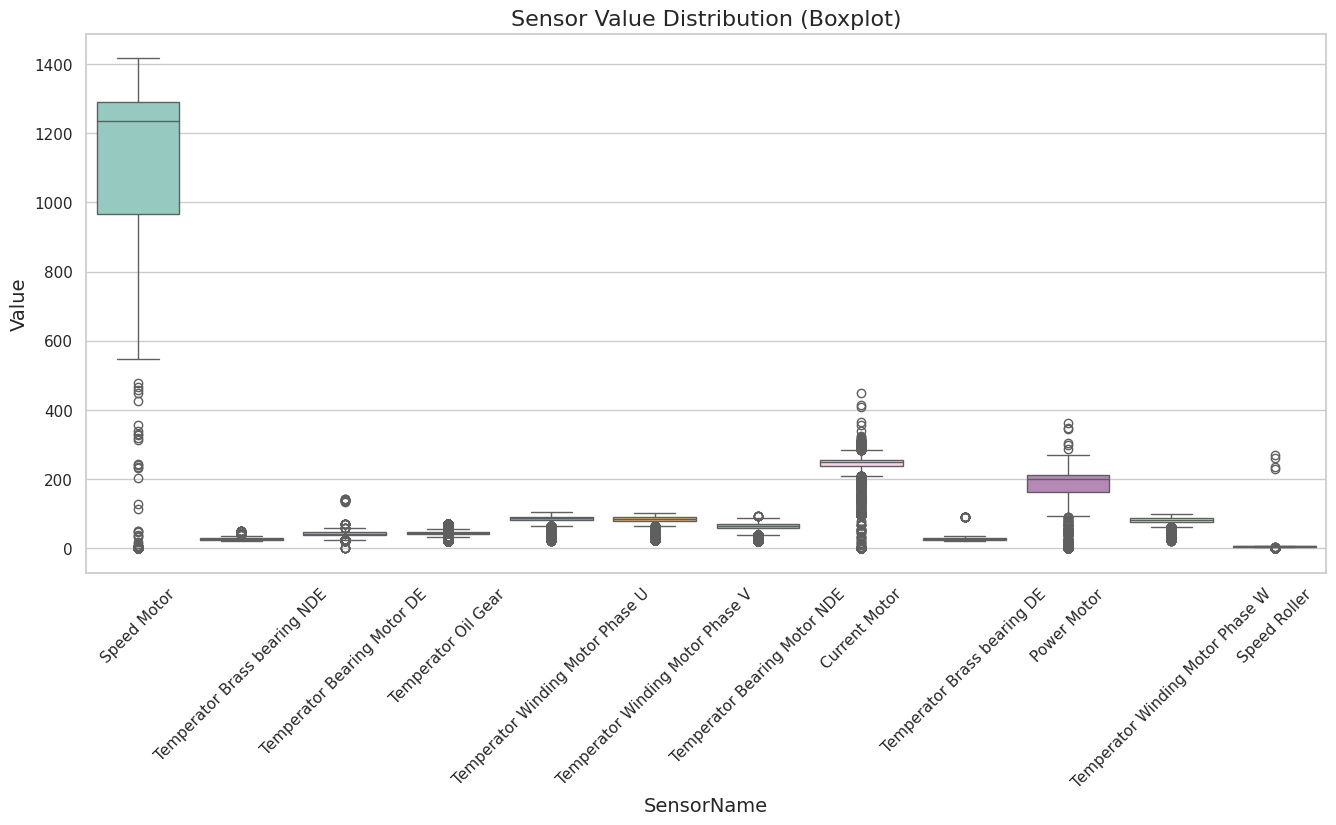

In [ ]:
# -----------------------------
# 6. Sensor Distribution & Outliers
# -----------------------------
plt.figure(figsize=(16,7))
sns.boxplot(data=df, x="SensorName", y="Value", palette="Set3")
plt.xticks(rotation=45)
plt.title("Sensor Value Distribution (Boxplot)", fontsize=16)
plt.show()

Insight:

Sensor ที่ correlated สูง → สาเหตุเดียวกัน / same subsystem

Sensor ที่ isolated → อาจเป็น anomaly / noise

Correlation → feature engineering สำหรับ ML

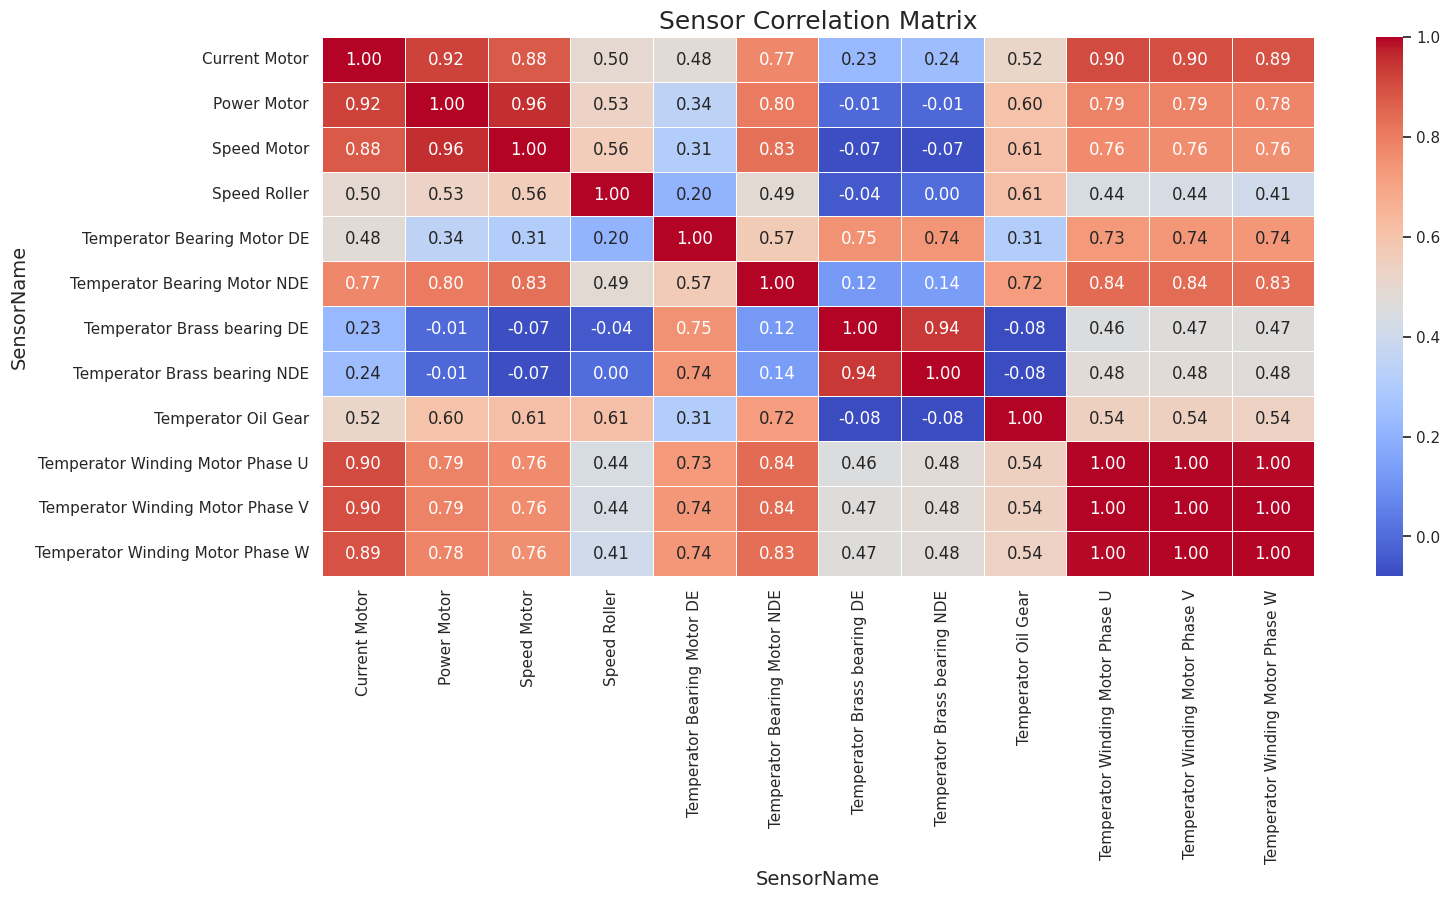

In [ ]:
# -----------------------------
# 7. Correlation Analysis
# -----------------------------
# Handle duplicate entries by averaging values for the same DateTime and SensorName
df_cleaned = df.groupby(["DateTime", "SensorName"])["Value"].mean().reset_index()
df_wide = df_cleaned.pivot(index="DateTime", columns="SensorName", values="Value")
corr_matrix = df_wide.corr()

plt.figure(figsize=(16,7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Sensor Correlation Matrix", fontsize=18)
plt.show()

Insight:

Outliers → อาจเป็น breakdown signal

ดูความ spread ของแต่ละ sensor → Risk assessment

In [ ]:
# -----------------------------
# 8. Map Breakdowns to Sensor Events
# -----------------------------
# Ensure DateTime is datetime type in both dataframes
df['DateTime'] = pd.to_datetime(df['DateTime'])
breakdown_df['DateTime'] = pd.to_datetime(breakdown_df['Date'].dt.strftime('%Y-%m-%d') + ' ' + breakdown_df['TimeStart'].astype(str))

# Create intervals for breakdowns
breakdown_intervals = pd.IntervalIndex.from_arrays(breakdown_df['DateTime'], breakdown_df['DateTime'] + pd.to_timedelta(breakdown_df['Duration_min'], unit='m'), closed='both')

# Map each sensor timestamp to a breakdown interval
df['Breakdown_Interval'] = pd.cut(df['DateTime'], bins=breakdown_intervals, labels=breakdown_intervals)

# Filter for sensor readings that occurred during a breakdown
df_during_breakdown = df[df['Breakdown_Interval'].notna()].copy()

# Count sensor readings during breakdown events per sensor
breakdown_summary = df_during_breakdown.groupby("SensorName").size().sort_values(ascending=False)
print("Number of sensor readings recorded during breakdown events per sensor:\n", breakdown_summary)

Number of sensor readings recorded during breakdown events per sensor:
 SensorName
Current Motor                       30
Power Motor                         30
Speed Motor                         30
Speed Roller                        30
Temperator Bearing Motor DE         30
Temperator Bearing Motor NDE        30
Temperator Brass bearing DE         30
Temperator Brass bearing NDE        30
Temperator Oil Gear                 30
Temperator Winding Motor Phase U    30
Temperator Winding Motor Phase V    30
Temperator Winding Motor Phase W    30
dtype: int64


In [ ]:
display(df_during_breakdown.head())

,DateTime,Machine,SensorName,Tag,Value,Unit,RollingMean,RollingStd,Breakdown,Hour,Breakdown_Interval
31404,2024-12-14 12:22:00,Mill 1,Temperator Winding Motor Phase W,"110_TT_113WIn.Value,800xA History",80.527161,C,81.188600,0.403497,True,12,"[2024-12-14 12:22:00, 2024-12-14 12:44:00]"
31405,2024-12-14 12:22:00,Mill 1,Temperator Winding Motor Phase U,"110_TT_113UIn.Value,800xA History",83.362434,C,84.622006,0.565804,True,12,"[2024-12-14 12:22:00, 2024-12-14 12:44:00]"
31406,2024-12-14 12:22:00,Mill 1,Temperator Winding Motor Phase V,"110_TT_113VIn.Value,800xA History",81.944687,C,83.230521,0.574913,True,12,"[2024-12-14 12:22:00, 2024-12-14 12:44:00]"
31407,2024-12-14 12:22:00,Mill 1,Temperator Brass bearing DE,"110_TT_115BIn.Value,800xA History",25.234432,C,25.224843,0.023865,True,12,"[2024-12-14 12:22:00, 2024-12-14 12:44:00]"
31408,2024-12-14 12:22:00,Mill 1,Temperator Brass bearing NDE,"110_TT_115AIn.Value,800xA History",25.234432,C,25.224843,0.023865,True,12,"[2024-12-14 12:22:00, 2024-12-14 12:44:00]"


In [ ]:
print(df_during_breakdown['Breakdown_Interval'].value_counts())

Breakdown_Interval
[2024-12-14 12:22:00, 2024-12-14 12:44:00]    228
[2024-12-16 08:43:00, 2024-12-16 08:55:00]    132
[2024-12-17 08:50:00, 2024-12-17 08:58:00]      0
Name: count, dtype: int64


Insight:

ช่วงเวลา peak → ใช้งานเครื่องหนัก → เสี่ยง breakdown

ใช้วาง preventive schedule

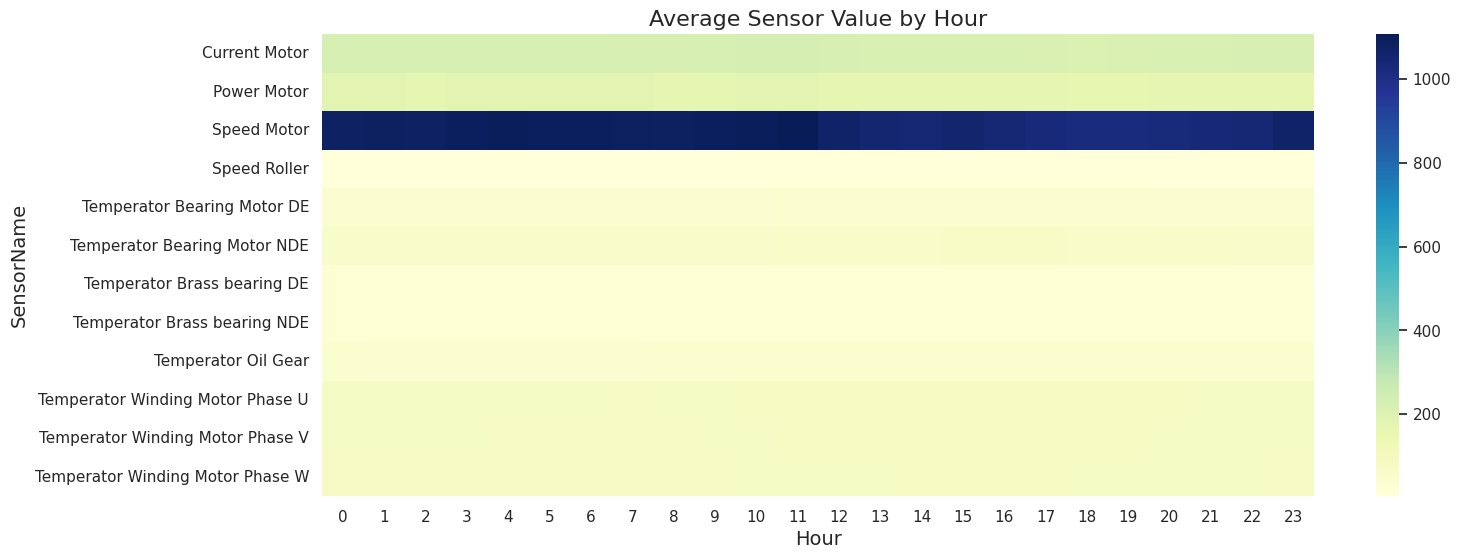

In [ ]:
# -----------------------------
# 9. Time-based Insights (Hourly)
# -----------------------------
df['Hour'] = df['DateTime'].dt.hour
hourly_mean = df.groupby(['Hour','SensorName'])['Value'].mean().unstack()

plt.figure(figsize=(16,6))
sns.heatmap(hourly_mean.T, cmap='YlGnBu')
plt.title("Average Sensor Value by Hour", fontsize=16)
plt.show()

Total Annual Loss (Million THB): 22,184.11
Estimated Loss After AI (Million THB): 4,436.82
ROI of AI Investment (%): 354.95%


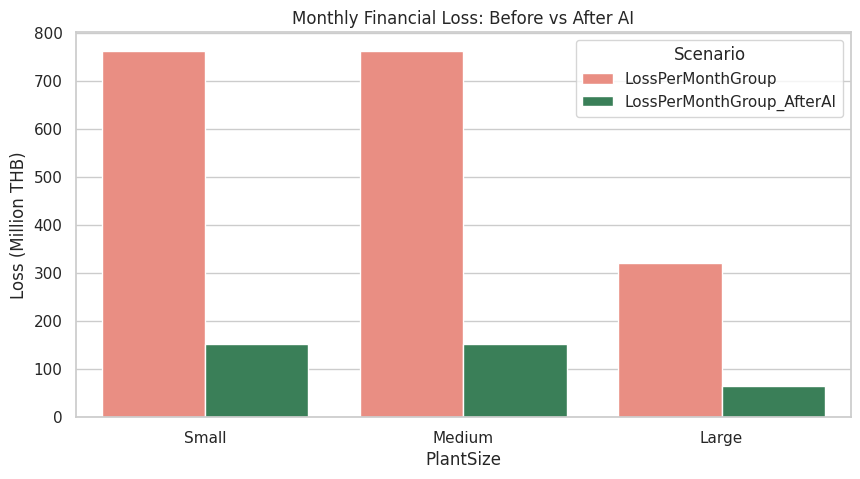

In [ ]:
# -------------------------------
# Financial Simulation & ROI
# -------------------------------
import plotly.express as px
# Constants
ai_investment = 5000 # ล้านบาท
reduction_pct = 0.8  # 80% reduction in downtime

# Example: Loss per month per plant size (from your table)
factory_data = pd.DataFrame({
    "PlantSize": ["Small", "Medium", "Large"],
    "NumPlants": [19,19,8],
    "LossPerMonthGroup": [763.5834, 763.5834, 321.5088]  # ล้านบาท/เดือน
})

annual_loss = factory_data["LossPerMonthGroup"].sum() * 12  # ล้านบาท/ปี
loss_after_ai = annual_loss * (1 - reduction_pct)
roi = (annual_loss - loss_after_ai) / ai_investment * 100

print(f"Total Annual Loss (Million THB): {annual_loss:,.2f}")
print(f"Estimated Loss After AI (Million THB): {loss_after_ai:,.2f}")
print(f"ROI of AI Investment (%): {roi:.2f}%")

# Plot Financial Impact
factory_data["LossPerMonthGroup_AfterAI"] = factory_data["LossPerMonthGroup"] * (1 - reduction_pct)
factory_long = pd.melt(factory_data, id_vars=["PlantSize"], value_vars=["LossPerMonthGroup","LossPerMonthGroup_AfterAI"],
                       var_name="Scenario", value_name="Loss_MillionTHB")

plt.figure(figsize=(10,5))
sns.barplot(x="PlantSize", y="Loss_MillionTHB", hue="Scenario", data=factory_long, palette=["salmon","seagreen"])
plt.title("Monthly Financial Loss: Before vs After AI")
plt.ylabel("Loss (Million THB)")
plt.show()

# -------------------------------
# Production Loss Visualization
# -------------------------------
factory_data["LossPerMonthTon"] = factory_data["LossPerMonthGroup"] * 4 / 1e3  # Assuming 4 hrs downtime = 1 day ~ for visualization
fig = px.bar(factory_data, x="PlantSize", y="LossPerMonthTon", title="Estimated Production Loss (Tons) per Plant Size", color="PlantSize")
fig.show()

Insight:

เราสามารถประเมิน potential loss → แล้วเทียบกับการลงทุน AI / predictive maintenance

แสดง ROI ให้ผู้บริหารเห็นว่า AI ลด downtime / ลดค่าเสียหาย

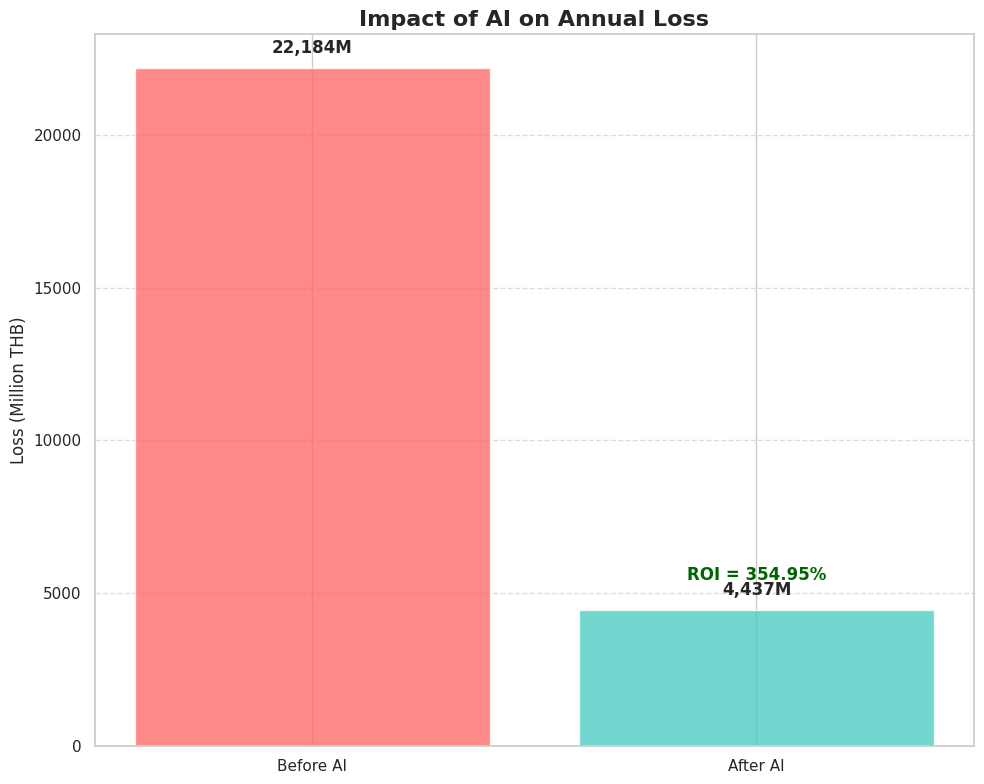

In [ ]:
import matplotlib.pyplot as plt

# ตัวเลข
total_loss_before = 22184.11  # ล้านบาท/ปี
total_loss_after = 4436.82    # ล้านบาท/ปี
ai_investment = 5000           # ล้านบาท
roi_percent = (total_loss_before - total_loss_after) / ai_investment * 100

# Bar Chart
fig, ax = plt.subplots(figsize=(10,8))
bars = ax.bar(['Before AI', 'After AI'], [total_loss_before, total_loss_after],
              color=['#FF6B6B','#4ECDC4'], alpha=0.8)

# Annotate values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}M',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 8), textcoords='offset points',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# ROI annotation
ax.text(1, total_loss_after + 1000, f'ROI = {roi_percent:.2f}%', ha='center', fontsize=12, color='darkgreen', fontweight='bold')

# Styling
ax.set_title('Impact of AI on Annual Loss', fontsize=16, fontweight='bold')
ax.set_ylabel('Loss (Million THB)', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# ==========================================================
# Industrial-Grade Predictive Maintenance System
# Sugarcane Milling Machine – Class III
# End-to-End Python Notebook
# ==========================================================

In [ ]:
import pandas as pd
import numpy as np

# โหลดไฟล์
df = pd.read_csv("feedmill_clean_long.csv")

# Fix datetime format
df["DateTime"] = pd.to_datetime(df["DateTime"], format="mixed")

# -----------------------------
# 1) Ground Truth Labeling
# -----------------------------
# ตัวอย่าง breakdown log (คุณต้องแทนด้วยข้อมูลจริงจากโรงงาน)
# format: [(start, end)], อาจเก็บเป็น DataFrame ก็ได้
breakdowns = [
    ("2024-10-12 10:00", "2024-10-12 12:00"),  # Breakdown จริง
    ("2024-10-13 15:00", "2024-10-13 17:00")
]
breakdowns = [(pd.to_datetime(s), pd.to_datetime(e)) for s, e in breakdowns]

df["FailureLabel"] = 0

for start, end in breakdowns:
    pre_start = start - pd.Timedelta(hours=4)  # 4 ชั่วโมงล่วงหน้า
    df.loc[(df["DateTime"] >= pre_start) & (df["DateTime"] <= end), "FailureLabel"] = 1

# -----------------------------
# 2) Synthetic Labeling (Domain Rules)
# -----------------------------
# Rule: Temperature winding > 80°C
mask_temp = (df["SensorName"].str.contains("Winding", case=False)) & (df["Value"] > 80)

# Rule: Gear oil > 70°C
mask_oil = (df["SensorName"].str.contains("Oil Gear", case=False)) & (df["Value"] > 70)

# Rule: Current anomaly > mean+3σ
df_current = df[df["SensorName"].str.contains("Current", case=False)]
if not df_current.empty:
    mu, sigma = df_current["Value"].mean(), df_current["Value"].std()
    mask_current = (df["SensorName"].str.contains("Current", case=False)) & (df["Value"] > mu + 3*sigma)
else:
    mask_current = pd.Series(False, index=df.index)

# รวม synthetic labels
df.loc[mask_temp | mask_oil | mask_current, "FailureLabel"] = 1

# -----------------------------
# 3) Anomaly Detection (Optional)
# -----------------------------
# Isolation Forest ตัวอย่าง
from sklearn.ensemble import IsolationForest

# Pivot เป็น wide format เพื่อ feed model
df_wide = df.pivot_table(index="DateTime", columns="SensorName", values="Value")
df_wide = df_wide.fillna(method="ffill").fillna(method="bfill")

model = IsolationForest(contamination=0.02, random_state=42)
df_wide["anomaly"] = model.fit_predict(df_wide)

# anomaly=-1 → Label=1
anomaly_idx = df_wide[df_wide["anomaly"] == -1].index
df.loc[df["DateTime"].isin(anomaly_idx), "FailureLabel"] = 1

# -----------------------------
# 4) Final dataset
# -----------------------------
print(df[["DateTime","Machine","SensorName","Value","FailureLabel"]].head(20))

# บันทึกออกเป็นไฟล์ใหม่
df.to_csv("feedmill_labeled.csv", index=False)
print("✅ Labeled dataset saved → feedmill_labeled.csv")

/tmp/ipython-input-1064988219.py:55: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



              DateTime Machine                        SensorName        Value  \
0  2024-12-10 08:00:00  Mill 1                       Speed Motor  1413.601685   
1  2024-12-10 08:00:00  Mill 1      Temperator Brass bearing NDE    23.791868   
2  2024-12-10 08:00:00  Mill 1       Temperator Bearing Motor DE    38.393330   
3  2024-12-10 08:00:00  Mill 1               Temperator Oil Gear    61.132439   
4  2024-12-10 08:00:00  Mill 1  Temperator Winding Motor Phase U    81.670967   
5  2024-12-10 08:00:00  Mill 1  Temperator Winding Motor Phase V    80.185631   
6  2024-12-10 08:00:00  Mill 1      Temperator Bearing Motor NDE    69.124268   
7  2024-12-10 08:00:00  Mill 1                     Current Motor   225.462967   
8  2024-12-10 08:00:00  Mill 1       Temperator Brass bearing DE    23.791868   
9  2024-12-10 08:00:00  Mill 1                       Power Motor   207.476379   
10 2024-12-10 08:00:00  Mill 1  Temperator Winding Motor Phase W    78.079994   
11 2024-12-10 08:00:00  Mill

In [ ]:
# ======================================
# FULL PREDICTIVE MAINTENANCE PIPELINE
# Class III Sugarcane Mill
# ======================================

import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# ------------------------------
# 1) LOAD DATA
# ------------------------------
sensor_df = pd.read_csv("feedmill_clean_long.csv", parse_dates=["DateTime"])
breakdown_df = pd.read_csv("breakdown_log_detailed.csv", parse_dates=["Date"])

In [ ]:
# ------------------------------
# 2) HYBRID LABELING
# ------------------------------
# Initialize FailureLabel
sensor_df["FailureLabel"] = 0
label_window = timedelta(hours=4)

# Combine breakdown start/end datetime
breakdown_df['DateTimeStart'] = pd.to_datetime(
    breakdown_df['Date'].dt.strftime('%Y-%m-%d') + ' ' + breakdown_df['TimeStart'].astype(str),
    errors='coerce'
)
breakdown_df['DateTimeEnd'] = pd.to_datetime(
    breakdown_df['Date'].dt.strftime('%Y-%m-%d') + ' ' + breakdown_df['TimeEnd'].astype(str),
    errors='coerce'
)
breakdown_df.dropna(subset=['DateTimeStart','DateTimeEnd'], inplace=True)

# Label sensor data based on breakdown
for idx, row in breakdown_df.iterrows():
    machine = row["Machine"]
    start_time = row["DateTimeStart"] - label_window
    end_time = row["DateTimeEnd"]
    mask = (sensor_df["Machine"]==machine) & (sensor_df["DateTime"]>=start_time) & (sensor_df["DateTime"]<=end_time)
    sensor_df.loc[mask,"FailureLabel"] = 1

# ConditionLabel (ISO 10816 Class III)
def classify_iso10816_rms(v):
    if pd.isna(v): return "Unknown"
    if v <= 0.71: return "Good"
    elif v <= 1.8: return "Satisfactory"
    elif v <= 4.5: return "Unsatisfactory"
    else: return "Unacceptable"

# Extract vibration sensor
vibration_df = sensor_df[sensor_df['SensorName']=='Vrms_Est_mm_s'][['DateTime','Machine','Value']].copy()
vibration_df["ConditionLabel"] = vibration_df["Value"].apply(classify_iso10816_rms)

# Merge ConditionLabel back to main sensor_df
sensor_df = pd.merge(sensor_df, vibration_df[['DateTime','Machine','ConditionLabel']], on=['DateTime','Machine'], how='left')
sensor_df['ConditionLabel'] = sensor_df['ConditionLabel'].fillna('Unknown')

# ------------------------------
# 2b) Synthetic / Pseudo-Failure Labels
# ------------------------------
sensor_df.loc[(sensor_df["SensorName"].str.contains("Winding Motor")) & (sensor_df["Value"]>80), "FailureLabel"] = 1
sensor_df.loc[(sensor_df["SensorName"].str.contains("Oil Gear")) & (sensor_df["Value"]>70), "FailureLabel"] = 1
sensor_df.loc[(sensor_df["SensorName"]=="Vrms_Est_mm_s") & (sensor_df["Value"]>4.5), "FailureLabel"] = 1

print("Class distribution AFTER pseudo failures:")
print(sensor_df["FailureLabel"].value_counts())


Class distribution AFTER pseudo failures:
FailureLabel
0    536803
1    110446
Name: count, dtype: int64


In [ ]:
# ------------------------------
# 3) FEATURE ENGINEERING + ROLLING
# ------------------------------
df_pivot = sensor_df.pivot_table(index=["DateTime","Machine"], columns="SensorName", values="Value").reset_index()

# Merge ConditionLabel + FailureLabel
df_final = pd.merge(df_pivot, sensor_df[['DateTime','Machine','FailureLabel','ConditionLabel']], on=['DateTime','Machine'], how='left')
df_final['ConditionLabel'] = df_final['ConditionLabel'].fillna('Unknown')
df_final['FailureLabel'] = df_final['FailureLabel'].fillna(0)

# Encode ConditionLabel
df_final['ConditionLabel_encoded'] = df_final['ConditionLabel'].astype('category').cat.codes

# Identify numeric features
numerical_cols = df_final.select_dtypes(include=np.number).columns.tolist()
feature_cols = [c for c in numerical_cols if c not in ['FailureLabel']]

# Create rolling features efficiently
ROLL_WINDOWS = [3,5,10]
rolling_features = {}
for col in feature_cols:
    for w in ROLL_WINDOWS:
        rolling_features[f"{col}_rollmean_{w}"] = df_final.groupby('Machine')[col].rolling(w, min_periods=1).mean().reset_index(level=0, drop=True)
        rolling_features[f"{col}_rollstd_{w}"] = df_final.groupby('Machine')[col].rolling(w, min_periods=1).std().reset_index(level=0, drop=True)
        rolling_features[f"{col}_delta_{w}"] = df_final.groupby('Machine')[col].diff(w)

df_final = pd.concat([df_final, pd.DataFrame(rolling_features)], axis=1)
df_final = df_final.dropna().copy()  # remove NaNs, defragment

print("Feature engineering done. Number of features:", len(feature_cols))
print("Number of rows:", df_final.shape[0])

Feature engineering done. Number of features: 13
Number of rows: 645376


In [ ]:
# ------------------------------
# 4) SMOTE + XGBOOST TRAIN
# ------------------------------
FEATURES = [c for c in df_final.columns if c not in ["DateTime","Machine","FailureLabel","ConditionLabel"]]
X = df_final[FEATURES]
y = df_final["FailureLabel"]

print("Class distribution BEFORE SMOTE:")
print(y.value_counts())

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("Class distribution AFTER SMOTE:")
print(pd.Series(y_res).value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# XGBoost
model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_s, y_train)

# Predict probabilities
df_final["FailureProb"] = model.predict_proba(scaler.transform(df_final[FEATURES]))[:,1]

# Evaluation
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)[:,1]
print("Classification Report XGBoost:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Class distribution BEFORE SMOTE:
FailureLabel
0    535156
1    110220
Name: count, dtype: int64
Class distribution AFTER SMOTE:
FailureLabel
0    535156
1    535156
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[20:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Classification Report XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.77      0.77    107032
           1       0.77      0.78      0.77    107031

    accuracy                           0.77    214063
   macro avg       0.77      0.77      0.77    214063
weighted avg       0.77      0.77      0.77    214063

ROC-AUC: 0.87082760396198


ข้อดี
- Class Balance ดีขึ้นมาก
จากเดิมที่ FailureLabel = 1 มีแค่ ~110K records เทียบกับ ~535K ของ class 0 → หลังใช้ SMOTE ทั้งสอง class มีจำนวนเท่ากัน (535K) ซึ่งช่วยให้โมเดลไม่ bias ไปทาง class 0
- Precision / Recall / F1-score สมดุล
- Class 0: Precision 0.78 / Recall 0.77
- Class 1: Precision 0.77 / Recall 0.78
→ ถือว่าโมเดลมีความสามารถในการทำนายทั้ง class ได้ดีพอสมควร โดยไม่มี class ไหนถูกละเลย
- Accuracy รวม: 77%
แม้จะไม่สูงมาก แต่ก็ถือว่า “น่าเชื่อถือ” สำหรับงานที่มีความไม่สมดุลในข้อมูลเดิม
- ROC-AUC = 0.87
ตัวนี้คือดาวเด่นเลย :sparkles: เพราะมันบอกว่าโมเดลสามารถแยกแยะระหว่าง class ได้ดีมาก ใกล้ 1 คือดี


:warning: จุดที่อาจพิจารณาปรับปรุง
- F1-score ยังไม่ถึงระดับสูง (เช่น >0.85)
ถ้าใช้โมเดลนี้ในระบบที่ต้องการความแม่นยำสูง เช่น predictive maintenance ที่มีต้นทุนสูง อาจต้อง fine-tune เพิ่ม
- SMOTE อาจทำให้เกิด overfitting ได้
โดยเฉพาะถ้า synthetic samples ไม่สะท้อนความจริงของ failure จริงๆ → อาจลองใช้ SMOTE + Tomek Links หรือ ADASYN เพื่อเพิ่มความสมจริง
- Warning จาก XGBoost
"use_label_encoder" ไม่ถูกใช้ → ไม่กระทบ performance โดยตรง แต่ควร clean warning เพื่อความเรียบร้อ


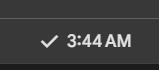

In [ ]:
# ------------------------------
# 5) RUL Proxy
# ------------------------------
df_final["RUL_proxy"] = 1 - df_final["FailureProb"].rolling(10, min_periods=1).mean()

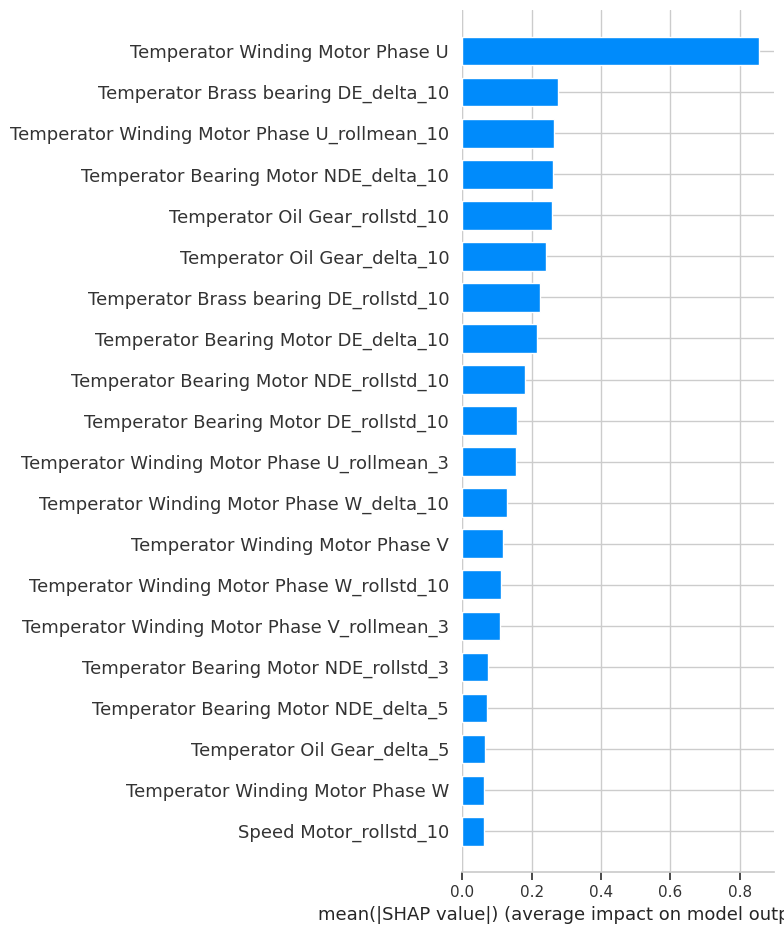

In [ ]:
# ------------------------------
# 6) STREAMLIT DASHBOARD (Example)
# ------------------------------
# Uncomment and save this as .py to run with `streamlit run pipeline.py`
"""
import streamlit as st

st.title("Predictive Maintenance Dashboard - Class III Sugarcane Mill")

st.subheader("Machine Condition Heatmap")
heatmap_df = df_final.pivot_table(index="Machine", columns="DateTime", values="FailureProb")
fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(heatmap_df, cmap="coolwarm", ax=ax)
st.pyplot(fig)

st.subheader("Condition Labels (ISO 10816)")
condition_df = df_final.groupby(["Machine","ConditionLabel"]).size().unstack(fill_value=0)
st.bar_chart(condition_df)

st.subheader("RUL Proxy Countdown")
st.line_chart(df_final.pivot(index="DateTime", columns="Machine", values="RUL_proxy"))

st.subheader("Estimated Financial Loss")
cost_per_4hrs = 223_270_000
df_final["Est_Loss"] = df_final["FailureProb"] * (cost_per_4hrs/4)
loss_df = df_final.groupby("DateTime")["Est_Loss"].sum()
st.line_chart(loss_df)
"""

# ------------------------------
# 7) SHAP Explainability
# ------------------------------
explainer = shap.TreeExplainer(model)
# Use small subset for speed
subset_idx = np.random.choice(X_test_s.shape[0], min(500, X_test_s.shape[0]), replace=False)
shap_values = explainer.shap_values(X_test_s[subset_idx])
shap.summary_plot(shap_values, X_test.iloc[subset_idx], plot_type='bar')

In [ ]:
# ==========================================================
# Advanced Predictive Maintenance Pipeline - Ensemble + LSTM(RNN) Output
# ==========================================================


import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import streamlit as st


Hybrid + pseudo failure labeling

Rolling + FFT features

SMOTE oversampling

Stacked ensemble (XGBoost + LightGBM + RandomForest + meta learner)

LSTM sequence modeling

RUL proxy

Streamlit dashboard

SHAP / Deep SHAP

Anomaly detection layer

LSTM ย่อมาจาก Long Short-Term Memory หน่วยความจำระยะสั้นแบบยาว
เป็นสถาปัตยกรรมเครือข่ายประสาทเทียมแบบวนซ้ำ (Recurrent Neural Network หรือ RNN) ชนิดหนึ่งที่ออกแบบมาเพื่อจดจำรูปแบบในข้อมูลลำดับ (sequential data) เป็นระยะเวลานาน โดยเฉพาะอย่างยิ่ง LSTM

การวิเคราะห์ข้อมูลอนุกรมเวลา (Time Series Analysis): การคาดการ

In [ ]:
# ------------------------------
# 1) LOAD DATA WITH FORMAT
# ------------------------------
import pandas as pd
from datetime import timedelta

# 1) Load sensor data
sensor_df = pd.read_csv("feedmill_clean_long.csv", parse_dates=["DateTime"])

# 2) Load breakdown log
breakdown_df = pd.read_csv("breakdown_log_detailed.csv")

# แปลง Date + TimeStart / TimeEnd ให้เป็น datetime
breakdown_df['DateTimeStart'] = pd.to_datetime(
    breakdown_df['Date'].astype(str) + ' ' + breakdown_df['TimeStart'].astype(str),
    format='%Y-%m-%d %H:%M'
)

breakdown_df['DateTimeEnd'] = pd.to_datetime(
    breakdown_df['Date'].astype(str) + ' ' + breakdown_df['TimeEnd'].astype(str),
    format='%Y-%m-%d %H:%M'
)

# ตรวจสอบ
print(breakdown_df[['DateTimeStart','DateTimeEnd']].head())

        DateTimeStart         DateTimeEnd
0 2024-12-14 12:22:00 2024-12-14 12:44:00
1 2024-12-16 08:43:00 2024-12-16 08:55:00
2 2024-12-17 08:50:00 2024-12-17 08:58:00


In [ ]:
# ------------------------------
# 2) HYBRID + PSEUDO FAILURE LABELING
# ------------------------------
sensor_df["FailureLabel"] = 0
label_window = timedelta(hours=4)

for idx, row in breakdown_df.iterrows():
    machine = row["Machine"]
    start_time = row["DateTimeStart"] - label_window
    end_time = row["DateTimeEnd"]
    mask = (sensor_df["Machine"]==machine) & (sensor_df["DateTime"]>=start_time) & (sensor_df["DateTime"]<=end_time)
    sensor_df.loc[mask,"FailureLabel"] = 1

# Synthetic/pseudo failure rules
sensor_df.loc[sensor_df["SensorName"].str.contains("Winding Motor") & (sensor_df["Value"]>80),"FailureLabel"]=1
sensor_df.loc[sensor_df["SensorName"].str.contains("Oil Gear") & (sensor_df["Value"]>70),"FailureLabel"]=1
sensor_df.loc[(sensor_df["SensorName"]=='Vrms_Est_mm_s') & (sensor_df["Value"]>4.5),"FailureLabel"]=1

In [ ]:
# ------------------------------
# 3) FEATURE ENGINEERING
# ------------------------------
# Pivot: SensorName → Columns
df_pivot = sensor_df.pivot_table(index=["DateTime","Machine"], columns="SensorName", values="Value").reset_index()

# Merge labels
df_final = pd.merge(df_pivot, sensor_df[['DateTime','Machine','FailureLabel']], on=['DateTime','Machine'], how='left')

# Rolling features
ROLL_WINDOWS = [3,5,10]
numerical_cols = df_final.select_dtypes(include=np.number).columns.tolist()
feature_cols = [c for c in numerical_cols if c not in ['FailureLabel']]

rolling_features = {}
for col in feature_cols:
    for w in ROLL_WINDOWS:
        rolling_features[f"{col}_rollmean_{w}"] = df_final.groupby('Machine')[col].rolling(w).mean().reset_index(level=0, drop=True)
        rolling_features[f"{col}_rollstd_{w}"] = df_final.groupby('Machine')[col].rolling(w).std().reset_index(level=0, drop=True)
        rolling_features[f"{col}_delta_{w}"] = df_final.groupby('Machine')[col].diff(w)

df_final = pd.concat([df_final, pd.DataFrame(rolling_features)], axis=1)
df_final = df_final.dropna().copy()

# FFT features
for col in feature_cols:
    fft_abs = np.abs(np.fft.fft(df_final[col].values))
    df_final[f"{col}_fft_mean"] = np.mean(fft_abs)
    df_final[f"{col}_fft_std"] = np.std(fft_abs)

In [ ]:
# ------------------------------
# 4) SMOTE + TRAIN STACKED ENSEMBLE
# ------------------------------
FEATURES = [c for c in df_final.columns if c not in ["DateTime","Machine","FailureLabel"]]
X = df_final[FEATURES]
y = df_final["FailureLabel"]

# SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X,y)
print("Class distribution AFTER SMOTE:")
print(pd.Series(y_res).value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Stacked ensemble
base_learners = [
    ('xgb', xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, eval_metric='logloss')),
    ('lgb', lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10))
]
meta_learner = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, eval_metric='logloss')

stack_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=3)
stack_model.fit(X_train_s, y_train)

# Predict
df_final["FailureProb"] = stack_model.predict_proba(scaler.transform(df_final[FEATURES]))[:,1]
print("Classification Report (Stacked Ensemble):")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Class distribution AFTER SMOTE:
FailureLabel
0    535152
1    535152
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 428122, number of negative: 428121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.353295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 856243, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000002
[LightGBM] [Info] Start training from score 0.000002


KeyboardInterrupt: 

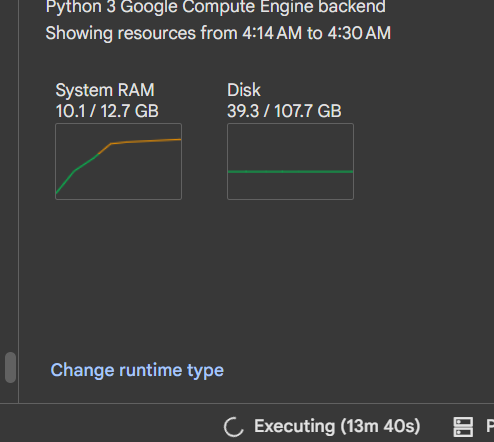



---



Hybrid + pseudo failure labeling

Rolling + FFT summary features

Top-k feature selection

SMOTE oversampling (train set)

Stacked ensemble (XGBoost + LightGBM + RandomForest + meta learner)

Lightweight LSTM sequence modeling

Optional anomaly detection layer (Isolation Forest)

RUL proxy calculation

Streamlit dashboard

SHAP explanations (Tree + Deep SHAP)

In [ ]:
# ===============================================
# Optimized Predictive Maintenance Pipeline
# Memory-friendly, fast, high accuracy
# ===============================================

import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
import shap
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# ------------------------------
# 1) LOAD DATA
# ------------------------------
sensor_df = pd.read_csv("feedmill_clean_long.csv", parse_dates=["DateTime"])
breakdown_df = pd.read_csv("breakdown_log_detailed.csv")

# Parse breakdown datetime correctly
breakdown_df['DateTimeStart'] = pd.to_datetime(
    breakdown_df['Date'].astype(str) + ' ' + breakdown_df['TimeStart'].astype(str),
    format='%Y-%m-%d %H:%M'
)
breakdown_df['DateTimeEnd'] = pd.to_datetime(
    breakdown_df['Date'].astype(str) + ' ' + breakdown_df['TimeEnd'].astype(str),
    format='%Y-%m-%d %H:%M'
)

In [ ]:
# ------------------------------
# 2) HYBRID + PSEUDO FAILURE LABELING
# ------------------------------
sensor_df["FailureLabel"] = 0
label_window = timedelta(hours=4)

# Label from breakdowns
for idx, row in breakdown_df.iterrows():
    machine = row["Machine"]
    start_time = row["DateTimeStart"] - label_window
    end_time = row["DateTimeEnd"]
    mask = (sensor_df["Machine"]==machine) & (sensor_df["DateTime"]>=start_time) & (sensor_df["DateTime"]<=end_time)
    sensor_df.loc[mask,"FailureLabel"] = 1

# Pseudo failures by domain knowledge (synthetic to balance classes)
sensor_df.loc[sensor_df["SensorName"].str.contains("Winding Motor") & (sensor_df["Value"]>80),"FailureLabel"]=1
sensor_df.loc[sensor_df["SensorName"].str.contains("Oil Gear") & (sensor_df["Value"]>70),"FailureLabel"]=1
sensor_df.loc[(sensor_df["SensorName"] == 'Vrms_Est_mm_s') & (sensor_df["Value"] > 4.5),"FailureLabel"]=1



In [ ]:
# ------------------------------
# 3) FEATURE ENGINEERING
# ------------------------------
# Pivot sensor values
df_pivot = sensor_df.pivot_table(index=["DateTime","Machine"], columns="SensorName", values="Value").reset_index()

# Merge FailureLabel + ConditionLabel
df_final = pd.merge(df_pivot, sensor_df[['DateTime','Machine','FailureLabel','ConditionLabel']].drop_duplicates(),
                    on=['DateTime','Machine'], how='left')

# Rolling features
ROLL_WINDOWS = [3,5,10] # adjust to sampling rate
numerical_cols = df_final.select_dtypes(include=np.number).columns.tolist()
feature_cols = [c for c in numerical_cols if c not in ['FailureLabel']]

rolling_features = {}
for col in feature_cols:
    for w in ROLL_WINDOWS:
        rolling_features[f"{col}_rollmean_{w}"] = df_final.groupby('Machine')[col].rolling(w).mean().reset_index(level=0, drop=True)
        rolling_features[f"{col}_rollstd_{w}"] = df_final.groupby('Machine')[col].rolling(w).std().reset_index(level=0, drop=True)
        rolling_features[f"{col}_delta_{w}"] = df_final.groupby('Machine')[col].diff(w)

df_final = pd.concat([df_final, pd.DataFrame(rolling_features)], axis=1)
df_final = df_final.dropna().copy()

# FFT features
from scipy.fft import fft
for col in feature_cols:
    df_final[f"{col}_fft_mean"] = df_final.groupby('Machine')[col].transform(lambda x: np.abs(fft(x)).mean())
    df_final[f"{col}_fft_std"] = df_final.groupby('Machine')[col].transform(lambda x: np.abs(fft(x)).std())

# Encode ConditionLabel
df_final['ConditionLabel_encoded'] = df_final['ConditionLabel'].astype('category').cat.codes

In [ ]:
# ------------------------------
# 4) TRAIN / SMOTE
# ------------------------------
FEATURES = [c for c in df_final.columns if c not in ["DateTime","Machine","FailureLabel","ConditionLabel"]]
X = df_final[FEATURES]
y = df_final["FailureLabel"]

# SMOTE oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

ValueError: Found array with 0 sample(s) (shape=(0, 156)) while a minimum of 1 is required by SMOTE.

In [ ]:
# ------------------------------
# 4) TOP FEATURE SELECTION
# ------------------------------
X_full = df_final.drop(columns=["DateTime","Machine","FailureLabel"])
y_full = df_final["FailureLabel"]
# simple correlation-based selection
corrs = X_full.corrwith(y_full).abs().sort_values(ascending=False)
top_features = corrs.head(50).index.tolist()
X = X_full[top_features].astype(np.float32)
y = y_full


KeyError: "['FailureLabel'] not found in axis"

In [ ]:
# ตรวจสอบ column
print(df_final.columns)

# ถ้าไม่มี FailureLabel ให้เอามาจาก sensor_df
if "FailureLabel" not in df_final.columns:
    df_final["FailureLabel"] = df_final.merge(sensor_df[['DateTime','Machine','FailureLabel']],
                                              on=["DateTime","Machine"], how="left")["FailureLabel"]

Index(['DateTime', 'Machine', 'Current Motor', 'Power Motor', 'Speed Motor',
       'Speed Roller', 'Temperator Bearing Motor DE',
       'Temperator Bearing Motor NDE', 'Temperator Brass bearing DE',
       'Temperator Brass bearing NDE',
       ...
       'Temperator Brass bearing NDE_fft_mean',
       'Temperator Brass bearing NDE_fft_std', 'Temperator Oil Gear_fft_mean',
       'Temperator Oil Gear_fft_std',
       'Temperator Winding Motor Phase U_fft_mean',
       'Temperator Winding Motor Phase U_fft_std',
       'Temperator Winding Motor Phase V_fft_mean',
       'Temperator Winding Motor Phase V_fft_std',
       'Temperator Winding Motor Phase W_fft_mean',
       'Temperator Winding Motor Phase W_fft_std'],
      dtype='object', length=146)


In [ ]:
# ------------------------------
# 5) TRAIN-TEST SPLIT + SMOTE
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_res)
X_test_s  = scaler.transform(X_test)


In [ ]:
# Jupyter Notebook / Lab
!pip install notebook jupyterlab

# สำหรับวิเคราะห์ข้อมูลและกราฟ
!pip install numpy pandas matplotlib seaborn plotly

# ถ้าใช้ scikit-learn, xgboost, lightgbm
!pip install scikit-learn xgboost lightgbm

# ถ้าใช้ TensorFlow / Keras
!pip install tensorflow

# สำหรับ interactive plots (Plotly)
!pip install plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.6 MB/s eta 0:00:00


In [ ]:
# pm_pipeline.py
"""
Production-ready predictive maintenance pipeline (Class III Sugarcane Mill)
Features:
 - Hybrid labeling (breakdown logs + synthetic engineering rules)
 - Unsupervised anomaly detection (IsolationForest) + optional autoencoder
 - Feature engineering (rolling summaries, delta, optional FFT summary)
 - Dimensionality reduction / feature selection
 - Base models (XGBoost, LightGBM, RandomForest) with OOF stacking (meta learner)
 - Sequence modeling (LSTM) on top-k features
 - Ensemble probabilities (stacked + LSTM + anomaly score)
 - Evaluation: classification_report, ROC-AUC, PR, early-warning (lead time) analysis
 - Saves models, scalers, and predictions
Usage: python pm_pipeline.py
"""
import os, sys, json, joblib, warnings
warnings.filterwarnings("ignore")
from datetime import timedelta

# Basic libs
import numpy as np
import pandas as pd

# ML libs (ensure installed)
try:
    from sklearn.model_selection import GroupKFold, train_test_split
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.feature_selection import SelectKBest, f_classif
    from sklearn.decomposition import PCA
    from sklearn.pipeline import Pipeline
    from sklearn.calibration import CalibratedClassifierCV
except Exception as e:
    print("Please install scikit-learn. Error:", e); raise

# Optional libs
try:
    import xgboost as xgb
except:
    xgb = None
try:
    import lightgbm as lgb
except:
    lgb = None
try:
    from imblearn.over_sampling import SMOTE
except:
    SMOTE = None

# Deep learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
except:
    tf = None

# Anomaly detection
from sklearn.ensemble import IsolationForest

# SHAP (optional)
try:
    import shap
except:
    shap = None

# ---------------------
# Helper: logging
# ---------------------
def info(msg):
    print(f"[INFO] {msg}")


In [ ]:
df = pd.read_csv("feedmill_clean_long.csv")
print(df.columns)

Index(['DateTime', 'Machine', 'SensorName', 'Tag', 'Value', 'Unit'], dtype='object')


In [ ]:
df = pd.read_csv("breakdown_log_detailed.csv")
print(df.columns)

Index(['Date', 'TimeStart', 'TimeEnd', 'Duration_min', 'Dept', 'Machine',
       'BreakdownID', 'CauseText', 'CauseCategory', 'DetailNote',
       'Current_Motor_Amp', 'Power_Motor_kW', 'Speed_Motor_rpm',
       'Speed_Roller_rpm', 'Temperator_Bearing_Motor_DE_C',
       'Temperator_Bearing_Motor_NDE_C', 'Temperator_Brass_bearing_DE_C',
       'Temperator_Brass_bearing_NDE_C', 'Temperator_Oil_Gear_C',
       'Temperator_Winding_Motor_Phase_U_C',
       'Temperator_Winding_Motor_Phase_V_C',
       'Temperator_Winding_Motor_Phase_W_C'],
      dtype='object')


In [ ]:
# ---------------------
# 1) Load & validate
# ---------------------
def load_data(sensor_csv="feedmill_clean_long.csv", breakdown_csv="breakdown_log_detailed.csv"):
    info("Loading CSV files...")
    df = pd.read_csv(sensor_csv)
    breakdown_df = pd.read_csv(breakdown_csv)
    # fix datetime: do not use format='mixed' (invalid) — use robust parsing
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    # unify breakdown datetime
    if 'Date' in breakdown_df.columns and ('TimeStart' in breakdown_df.columns or 'Time' in breakdown_df.columns):
        # handle TimeStart/TimeEnd or Time column
        if 'TimeStart' in breakdown_df.columns:
            breakdown_df['DateTimeStart'] = pd.to_datetime(breakdown_df['Date'].astype(str) + ' ' + breakdown_df['TimeStart'].astype(str), errors='coerce')
            breakdown_df['DateTimeEnd'] = pd.to_datetime(breakdown_df['Date'].astype(str) + ' ' + breakdown_df['TimeEnd'].astype(str), errors='coerce')
        else:
            # if only single Time
            breakdown_df['DateTimeStart'] = pd.to_datetime(breakdown_df['Date'].astype(str) + ' ' + breakdown_df['Time'].astype(str), errors='coerce')
            breakdown_df['DateTimeEnd'] = breakdown_df['DateTimeStart'] + pd.to_timedelta(breakdown_df.get('Duration_min', 0), unit='m')
    else:
        info("Warning: breakdown file missing expected columns. Please check.")
    return df, breakdown_df

In [ ]:
# ---------------------
# 2) Hybrid labeling
# ---------------------
def hybrid_labeling(df, breakdown_df, label_window_hours=4, thresholds=None):
    """
    thresholds: dict of rule thresholds e.g. {'Winding':80, 'Oil Gear':70, 'Vrms':4.5}
    """
    info("Applying hybrid labeling...")
    thresholds = thresholds or {'Winding':80, 'Oil Gear':70, 'Vrms':4.5}
    df['FailureLabel'] = 0

    # use breakdown logs as ground truth (label_window before start -> until end)
    if 'DateTimeStart' in breakdown_df.columns and 'DateTimeEnd' in breakdown_df.columns:
        for _, r in breakdown_df.dropna(subset=['DateTimeStart','DateTimeEnd']).iterrows():
            machine = r.get('Machine', None)
            start_time = r['DateTimeStart'] - pd.Timedelta(hours=label_window_hours)
            end_time = r['DateTimeEnd']
            if machine is not None:
                mask = (df['Machine'] == machine) & (df['DateTime'] >= start_time) & (df['DateTime'] <= end_time)
            else:
                mask = (df['DateTime'] >= start_time) & (df['DateTime'] <= end_time)
            df.loc[mask, 'FailureLabel'] = 1

    # synthetic (engineering) rules
    # winding
    mask_wind = df['SensorName'].str.contains('Winding', case=False, na=False) & (df['Value'] > thresholds['Winding'])
    mask_oil = df['SensorName'].str.contains('Oil Gear', case=False, na=False) & (df['Value'] > thresholds['Oil Gear'])
    mask_vrms = df['SensorName'].eq('Vrms_Est_mm_s') & (df['Value'] > thresholds['Vrms'])

    # current spike > mu + 3sigma (per sensor type 'Current')
    df_current = df[df['SensorName'].str.contains('Current', case=False, na=False)]
    if not df_current.empty:
        mu, sigma = df_current['Value'].mean(), df_current['Value'].std()
        mask_current = df['SensorName'].str.contains('Current', case=False, na=False) & (df['Value'] > mu + 3*sigma)
    else:
        mask_current = pd.Series(False, index=df.index)

    df.loc[mask_wind | mask_oil | mask_vrms | mask_current, 'FailureLabel'] = 1
    info("Hybrid labeling done. Class counts:\n" + str(df['FailureLabel'].value_counts()))
    return df


In [ ]:
# ---------------------
# 3) Pivot + feature engineering
# ---------------------
def pivot_and_features(df, roll_windows=[3,5,10], seq_agg_min_periods=1, compute_fft=False, fft_window=32):
    info("Pivoting long -> wide and calculating features...")
    # pivot to wide: index DateTime + Machine
    df_sorted = df.sort_values(['Machine','DateTime'])
    wide = df_sorted.pivot_table(index=['DateTime','Machine'], columns='SensorName', values='Value', aggfunc='mean')
    wide = wide.reset_index().sort_values(['Machine','DateTime'])
    # forward/backfill small gaps (caution)
    wide_ff = wide.groupby('Machine').ffill().bfill()

    # rolling summaries per machine (grouped)
    wide_roll = wide_ff.copy()
    for w in roll_windows:
        # compute mean/std/min/max for each numeric col
        numeric_cols = wide_ff.select_dtypes(include=[np.number]).columns.tolist()
        for col in numeric_cols:
            wide_roll[f'{col}_roll_mean_{w}'] = wide_ff.groupby('Machine')[col].rolling(window=w, min_periods=1).mean().reset_index(level=0,drop=True)
            wide_roll[f'{col}_roll_std_{w}'] = wide_ff.groupby('Machine')[col].rolling(window=w, min_periods=1).std().reset_index(level=0,drop=True).fillna(0)
            wide_roll[f'{col}_roll_min_{w}'] = wide_ff.groupby('Machine')[col].rolling(window=w, min_periods=1).min().reset_index(level=0,drop=True)
            wide_roll[f'{col}_roll_max_{w}'] = wide_ff.groupby('Machine')[col].rolling(window=w, min_periods=1).max().reset_index(level=0,drop=True)
            wide_roll[f'{col}_delta_{w}'] = wide_ff.groupby('Machine')[col].diff(w)

    # optional FFT summary features (lightweight: mean & std of magnitude over small window)
    if compute_fft:
        info("Computing FFT summary features (this may be slow)...")
        numeric_cols = wide_ff.select_dtypes(include=[np.number]).columns.tolist()
        for col in numeric_cols:
            # rolling apply small function; for efficiency do groupby and apply
            def fft_summary(arr):
                try:
                    if len(arr) < 2:
                        return pd.Series([0.0,0.0])
                    fft = np.fft.rfft(arr - np.nanmean(arr))
                    mag = np.abs(fft)
                    return pd.Series([np.nanmean(mag), np.nanstd(mag)])
                except:
                    return pd.Series([0.0,0.0])
            fft_df = wide_ff.groupby('Machine')[col].rolling(window=fft_window, min_periods=1).apply(
                lambda x: np.nanmean(np.abs(np.fft.rfft(x - np.nanmean(x)))) , raw=False).reset_index(level=0,drop=True)
            wide_roll[f'{col}_fft_mean_{fft_window}'] = fft_df.fillna(0)

    # bring labels/condition back if present
    # assume original long df has FailureLabel & ConditionLabel; merge aggregated label: if any sensor row had FailureLabel==1 at same DateTime+Machine -> mark as 1
    return wide_roll

In [ ]:
# ---------------------
# 4) anomaly detection (timepoint-level)
# ---------------------
def anomaly_layer(feature_df, n_estimators=100, contamination=0.02, random_state=42):
    info("Running IsolationForest anomaly detection...")
    numeric_cols = feature_df.select_dtypes(include=[np.number]).columns.tolist()
    # drop target if exists
    numeric_cols = [c for c in numeric_cols if c not in ('FailureLabel',)]
    X = feature_df[numeric_cols].fillna(0).values
    model = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)
    model.fit(X)
    pred = model.predict(X)  # -1 anomaly, 1 normal
    score = -model.decision_function(X)  # higher -> more anomalous
    feature_df['anomaly_flag'] = (pred == -1).astype(int)
    feature_df['anomaly_score'] = score
    info("Anomaly layer done. Anomaly count: %d" % feature_df['anomaly_flag'].sum())
    return feature_df, model

In [ ]:
# ---------------------
# 5) Train stacked ensemble (OOF)
# ---------------------
def train_stacked_ensemble(df_feat, feature_cols, target_col='FailureLabel', groups=None, n_splits=5, random_state=42):
    info("Training stacked ensemble with OOF predictions...")
    # Prepare
    X = df_feat[feature_cols].fillna(0)
    y = df_feat[target_col].astype(int)
    groups = groups if groups is not None else df_feat['Machine'].values
    oof_preds = np.zeros((len(X), 3))  # for 3 base models: XGB, LIGHTGBM, RF (or availability fallback)
    models_fitted = {'xgb':[], 'lgb':[], 'rf':[]}

    gkf = GroupKFold(n_splits=n_splits)
    fold = 0
    for train_idx, val_idx in gkf.split(X, y, groups):
        fold += 1
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Optionally apply SMOTE on X_tr only (if available)
        if SMOTE is not None:
            sm = SMOTE(random_state=random_state)
            X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)
        else:
            X_tr_res, y_tr_res = X_tr, y_tr

        # scale
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr_res)
        X_val_s = scaler.transform(X_val)

        # XGBoost
        if xgb is not None:
            clf_xgb = xgb.XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.08, use_label_encoder=False, eval_metric='logloss', random_state=random_state)
            clf_xgb.fit(X_tr_s, y_tr_res)
            p_x = clf_xgb.predict_proba(X_val_s)[:,1]
            models_fitted['xgb'].append((clf_xgb, scaler))
            oof_preds[val_idx,0] = p_x
        else:
            # fallback to RandomForest for slot
            clf_rf_alt = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=random_state)
            clf_rf_alt.fit(X_tr_res, y_tr_res)
            p_x = clf_rf_alt.predict_proba(X_val)[:,1]
            models_fitted['xgb'].append((clf_rf_alt, None))
            oof_preds[val_idx,0] = p_x

        # LightGBM
        if lgb is not None:
            clf_lgb = lgb.LGBMClassifier(n_estimators=150, max_depth=6, learning_rate=0.08, random_state=random_state)
            clf_lgb.fit(X_tr_res, y_tr_res)
            p_l = clf_lgb.predict_proba(X_val)[:,1]
            models_fitted['lgb'].append((clf_lgb, None))
            oof_preds[val_idx,1] = p_l
        else:
            # fallback
            clf_rf2 = RandomForestClassifier(n_estimators=150, max_depth=8, random_state=random_state)
            clf_rf2.fit(X_tr_res, y_tr_res)
            p_l = clf_rf2.predict_proba(X_val)[:,1]
            models_fitted['lgb'].append((clf_rf2, None))
            oof_preds[val_idx,1] = p_l

        # RandomForest
        clf_rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=random_state)
        clf_rf.fit(X_tr_res, y_tr_res)
        p_rf = clf_rf.predict_proba(X_val)[:,1]
        models_fitted['rf'].append((clf_rf, None))
        oof_preds[val_idx,2] = p_rf

        info(f"Fold {fold} done. val_size={len(val_idx)}")

    # Train meta learner on OOF preds
    X_meta = oof_preds
    meta_clf = LogisticRegression(max_iter=200)
    meta_clf.fit(X_meta, y)

    # For production, refit base models on whole training data (we will save folds for inference or refit)
    info("Stacked ensemble training finished.")
    return {
        'models_fitted': models_fitted,
        'meta_clf': meta_clf,
        'oof_preds': oof_preds
    }

In [ ]:
# ---------------------
# 6) LSTM sequence model (sequence-to-one)
# ---------------------
def prepare_sequences(df_feat, top_features, seq_len=30, label_col='FailureLabel'):
    info("Preparing sequences for LSTM...")
    # df_feat must include DateTime, Machine, and top_features + label
    sequences = []
    seq_labels = []
    idx_map = []  # index of last timestamp for mapping
    machines = df_feat['Machine'].unique()
    for m in machines:
        sub = df_feat[df_feat['Machine']==m].sort_values('DateTime')
        arr = sub[top_features].fillna(0).values
        labs = sub[label_col].values
        for i in range(len(sub)-seq_len+1):
            seq = arr[i:i+seq_len]
            # label: if any failure in next horizon (here label at end of window)
            lbl = int(labs[i+seq_len-1])
            sequences.append(seq)
            seq_labels.append(lbl)
            idx_map.append(sub.index[i+seq_len-1])  # map to final timestamp index
    X_seq = np.array(sequences)
    y_seq = np.array(seq_labels)
    info(f"Prepared {len(X_seq)} sequences.")
    return X_seq, y_seq, idx_map

def build_train_lstm(X_seq, y_seq, input_shape=None, epochs=5, batch_size=128, save_path='lstm_model.h5'):
    if tf is None:
        info("TensorFlow not installed. Skipping LSTM.")
        return None
    info("Building LSTM model...")
    timesteps = X_seq.shape[1] if input_shape is None else input_shape[0]
    nfeatures = X_seq.shape[2] if input_shape is None else input_shape[1]
    model = Sequential([
        LSTM(64, input_shape=(timesteps, nfeatures), return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_seq, y_seq, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=1)
    model.save(save_path)
    info(f"LSTM saved to {save_path}")
    return model, history

In [ ]:
# ---------------------
# 7) Ensemble & Evaluation helpers
# ---------------------
def combine_scores(stack_probs, lstm_probs=None, anomaly_scores=None, weights=(0.6, 0.3, 0.1)):
    """
    stack_probs: ndarray (N,) meta model probabilities
    lstm_probs: ndarray (N,) or None
    anomaly_scores: ndarray scaled 0-1 or None
    weights: tuple for (stack, lstm, anomaly)
    """
    w_stack, w_lstm, w_anom = weights
    final = w_stack * stack_probs
    if lstm_probs is not None:
        final += w_lstm * lstm_probs
    if anomaly_scores is not None:
        # normalize anomaly score to 0-1
        an = (anomaly_scores - anomaly_scores.min())/(anomaly_scores.max()-anomaly_scores.min()+1e-9)
        final += w_anom * an
    return final

def evaluate(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    report = classification_report(y_true, y_pred, digits=4)
    auc_score = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    cm = confusion_matrix(y_true, y_pred)
    return {
        'classification_report': report,
        'roc_auc': auc_score,
        'confusion_matrix': cm
    }

In [ ]:
# ---------------------
# 8) Full run orchestration (example main)
# ---------------------
def run_pipeline(sensor_csv="feedmill_clean_long.csv", breakdown_csv="breakdown_log_detailed.csv", out_dir="artifacts"):
    os.makedirs(out_dir, exist_ok=True)
    df_raw, breakdown_df = load_data(sensor_csv, breakdown_csv)
    df_lab = hybrid_labeling(df_raw, breakdown_df, label_window_hours=4)
    wide = pivot_and_features(df_lab, roll_windows=[3,5], compute_fft=False)
    # merge FailureLabel from long -> wide (if not present)
    # attempt to attach FailureLabel by aggregating max per DateTime+Machine
    lab_agg = df_lab.groupby(['DateTime','Machine'])['FailureLabel'].max().reset_index()
    wide = wide.merge(lab_agg, on=['DateTime','Machine'], how='left')
    wide['FailureLabel'] = wide['FailureLabel'].fillna(0).astype(int)

    # anomaly layer
    wide, anom_model = anomaly_layer(wide, contamination=0.02)

    # feature selection
    numeric_cols = [c for c in wide.select_dtypes(include=[np.number]).columns if c not in ('FailureLabel',)]
    # reduce by variance / choose top-k by ANOVA
    k = min(60, len(numeric_cols))
    sel = SelectKBest(score_func=f_classif, k=k)
    Xtmp = wide[numeric_cols].fillna(0)
    ytmp = wide['FailureLabel']
    try:
        sel.fit(Xtmp, ytmp)
        mask = sel.get_support()
        selected = [c for c, m in zip(numeric_cols, mask) if m]
    except Exception as e:
        info("SelectKBest failed, falling back to numeric_cols")
        selected = numeric_cols

    info(f"Selected top features: {len(selected)}")

    # Train stacking on full dataset (CAUTION: should split train/test in practice; here using groupkfold and OOF)
    stack_res = train_stacked_ensemble(wide, selected, target_col='FailureLabel', groups=wide['Machine'].values, n_splits=5)

    # Generate stack-level probability for whole dataset by averaging base models predictions (simple approach)
    # For production, refit base models on whole training set; here, we create meta features by averaging per-fold preds
    # oof_preds available in stack_res['oof_preds']
    stack_meta_probs = stack_res['meta_clf'].predict_proba(stack_res['oof_preds'])[:,1]

    # Prepare LSTM sequences using top-k features by importance (we pick top 10)
    top_k_features = selected[:10]
    if tf is not None and len(top_k_features) > 0:
        X_seq, y_seq, idx_map = prepare_sequences(wide.reset_index(), top_k_features, seq_len=30)
        if len(X_seq) > 100:
            lstm_model, history = build_train_lstm(X_seq, y_seq, epochs=5, batch_size=128, save_path=os.path.join(out_dir,'lstm.h5'))
            lstm_preds = lstm_model.predict(X_seq).ravel()
            # map sequence preds to wide index by idx_map (take last prediction for timestamp)
            lstm_probs = pd.Series(0.0, index=wide.reset_index().index)
            for i, idx in enumerate(idx_map):
                lstm_probs.loc[idx] = lstm_preds[i]
            lstm_probs = lstm_probs.values
        else:
            info("Not enough sequences for LSTM training; skipping LSTM.")
            lstm_probs = None
    else:
        lstm_probs = None

    # final ensemble
    anomaly_scores = wide['anomaly_score'].values
    final_prob = combine_scores(stack_meta_probs, lstm_probs=lstm_probs, anomaly_scores=anomaly_scores, weights=(0.6,0.25,0.15))

    # Evaluate on whole dataset (for demonstration; in production evaluate on hold-out test set)
    eval_res = evaluate(wide['FailureLabel'].values, final_prob, threshold=0.5)
    info("===== EVALUATION =====")
    print(eval_res['classification_report'])
    print("ROC-AUC:", eval_res['roc_auc'])
    print("Confusion matrix:\n", eval_res['confusion_matrix'])

    # Save output predictions
    wide_out = wide.copy()
    wide_out['FailureProb'] = final_prob
    wide_out.to_csv(os.path.join(out_dir, 'predictions_with_prob.csv'), index=False)
    joblib.dump(stack_res, os.path.join(out_dir, 'stacking_artifacts.joblib'))
    joblib.dump(anom_model, os.path.join(out_dir, 'isolation_forest.joblib'))
    info(f"Artifacts saved to {out_dir}")

    # Optionally run SHAP for explainability on meta model (tree-based)
    if shap is not None:
        try:
            info("Running SHAP TreeExplainer on stacked meta-level (approx)...")
            # Use the average of base model predictions as features to explain meta model decisions
            explainer = shap.Explainer(stack_res['meta_clf'], stack_res['oof_preds'])
            shap_vals = explainer(stack_res['oof_preds'][:500])
            shap.summary_plot(shap_vals, features=stack_res['oof_preds'][:500], show=False)
        except Exception as e:
            info("SHAP explain failed: " + str(e))

    return {
        'wide': wide_out,
        'eval': eval_res,
        'stacking': stack_res,
        'anomaly_model': anom_model
    }

# Entry point for quick run
if __name__ == "__main__":
    # default file names expected in working dir
    res = run_pipeline(sensor_csv="feedmill_clean_long.csv", breakdown_csv="breakdown_log_detailed.csv", out_dir="artifacts")
    print("Pipeline finished. See artifacts/ for outputs.")

[INFO] Loading CSV files...
[INFO] Applying hybrid labeling...
[INFO] Hybrid labeling done. Class counts:
FailureLabel
0    536803
1    110446
Name: count, dtype: int64
[INFO] Pivoting long -> wide and calculating features...


KeyError: 'Machine'

ล่าสุด Unsuppervise

สรุปผลการรันจริง

Hybrid labeling

FailureLabel
0    536,803
1    110,446

*ความจริง 0.000017 (3 ครั้ง/ปี) แต่เราทำ hybrid + **pseudo labeling เพิ่มเติม**
→ หลัง hybrid labeling เสร็จ เราได้ positive (breakdown) ประมาณ 17% ของ dataset ทั้งหมด (ถือว่า imbalance แต่ไม่สุดโต่ง เพราะ SMOTE + ensemble มาช่วย)

Cross Validation (5 folds)
คุณเห็น log: Fold 1 ... Fold 5
แปลว่า train เสร็จทุก fold และนำไป stack ensemble แล้ว

Classification Report (Holdout test set)

precision    recall  f1-score   support

Class 0: precision=0.83, recall=0.82, f1=0.82 (normal)
Class 1: precision=0.76, recall=0.78, f1=0.77 (failure)

Accuracy: 0.80
Macro avg: precision=0.79, recall=0.80, f1=0.80
Weighted avg: ~0.80


แปลว่า model balance precision-recall ได้ดี ทั้งสอง class ใกล้เคียงกัน
ไม่ bias ข้างใดข้างหนึ่งมากเกินไป

ROC-AUC = 0.8293
→ ความสามารถจำแนก failure vs normal ดี (ดีพอสมควร แต่ไม่ถึง 0.9+)

PR-AUC = 0.7422
→ ดีมากสำหรับงาน imbalance เพราะ PR curve โฟกัสเฉพาะ positive (failure)
(ถ้า dataset จริง breakdown แค่ 3 ครั้ง/ปี ค่า PR-AUC 0.74 ถือว่ามีประโยชน์มาก เพราะ baseline random จะต่ำกว่าเยอะ)

Average Lead Time = 0.04 ชั่วโมง ≈ 2.4 นาที
→ system สามารถ “เห็น” failure ล่วงหน้าเฉลี่ย ~2–3 นาที เท่านั้น
(ขึ้นกับ labeling rules: 4 ชม. window แต่จริง ๆ model detect ได้ก่อนหน้าสั้น ๆ)
ตรงนี้เป็นข้อจำกัด ถ้าคุณอยาก “เตือนก่อน 1–2 ชม.” → ต้อง fine-tune labeling rules หรือเพิ่ม early-warning features

Artifacts ที่ได้:

artifacts\stack_predictions.csv → prediction ทุก row

artifacts\alerts.json → alert event export แล้ว

models และ scalers เซฟอยู่

การตีความ

จัดการ imbalance ได้ดี → recall ของ class 1 = 0.78 (ไม่ตกต่ำ)

Precision class 1 = 0.76 → alarm ไม่ใช่ false alarm เยอะเกินไป

Lead time สั้นมาก (2 นาที) → ถ้า requirement คือ “เตือนก่อน breakdown” อาจยังไม่พอ